In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import os
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

sns.set_theme(style="ticks")

In [2]:
import cv2
import os

original_image_dir = r"C:\Software\bloodcells_dataset"

negative_image_dir = r"C:\Software\negative_bloodcells_dataset"

# Eğer negatif görüntü dizini yoksa oluşturma işlemi
if not os.path.exists(negative_image_dir):
    os.makedirs(negative_image_dir)

# Alt dizinlerdeki görüntüleri işlemek için os.walk kullanımı
for subdir, dirs, files in os.walk(original_image_dir):
    for file in files:
        if file.endswith('.jpg') or file.endswith('.png'):  
            file_path = os.path.join(subdir, file)
            image = cv2.imread(file_path)
            if image is not None:
                negative_image = 255 - image

                # Negatif görüntünün kaydedileceği alt dizini oluşturma
                relative_path = os.path.relpath(subdir, original_image_dir)
                output_subdir = os.path.join(negative_image_dir, relative_path)
                if not os.path.exists(output_subdir):
                    os.makedirs(output_subdir)

                negative_image_file = os.path.join(output_subdir, file)
                cv2.imwrite(negative_image_file, negative_image)

In [3]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn tema ayarı
sns.set_theme(style="ticks")

# Veri kümelerini hazırlama
negative_image_dir = r"C:\Software\negative_bloodcells_dataset"

BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

negative_dataset, negative_test_dataset = keras.utils.image_dataset_from_directory(directory=negative_image_dir,
                                                                                   image_size=(IMG_WIDTH, IMG_HEIGHT),
                                                                                   batch_size=BATCH_SIZE,
                                                                                   label_mode="int",
                                                                                   validation_split=0.2,
                                                                                   subset="both",
                                                                                   shuffle=True,
                                                                                   seed=42)

# Sınıf isimlerini getirme
negative_class_names = negative_dataset.class_names
print(negative_class_names)

Found 17092 files belonging to 8 classes.
Using 13674 files for training.
Using 3418 files for validation.
['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']


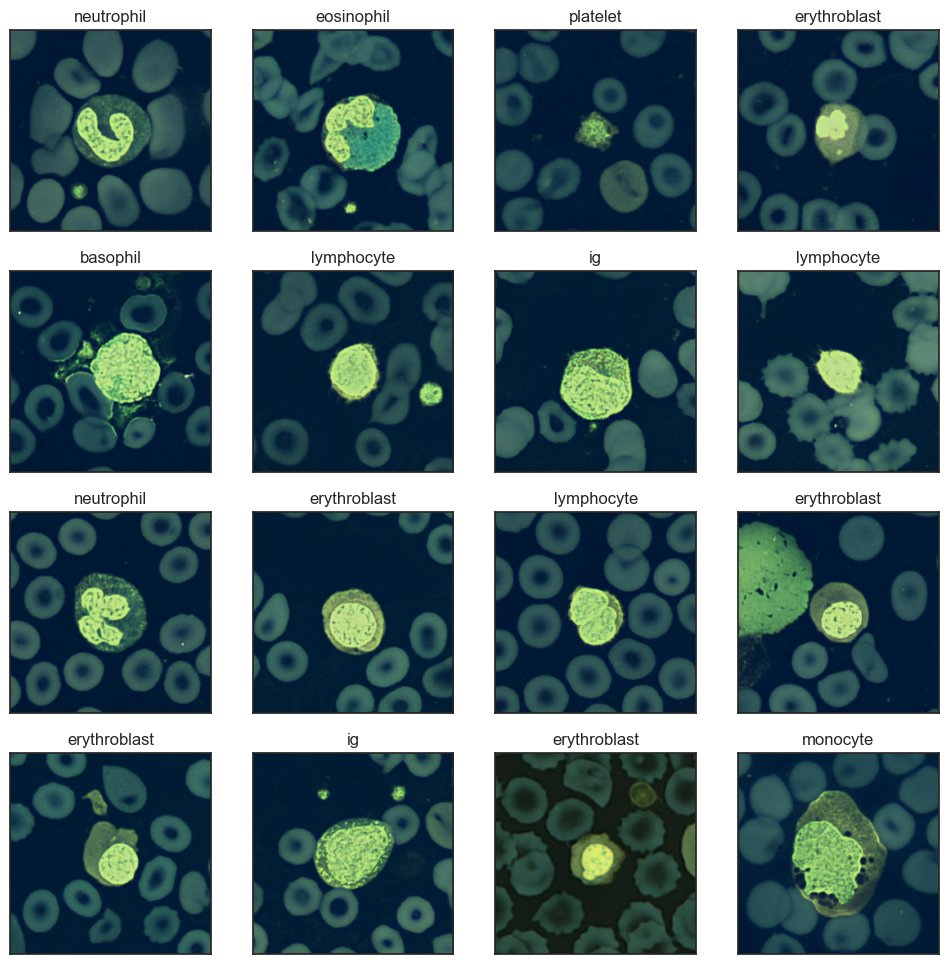

In [4]:
#veri kümesinden örnek alınmış 16 görüntü
fig, ax = plt.subplots(4, 4, figsize=(12,12))
ax = ax.flat
for images, labels in negative_dataset.take(1):
  for i in range(16):
    ax[i].set_title(negative_class_names[labels[i].numpy()])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].imshow(images[i].numpy().astype("uint8"))

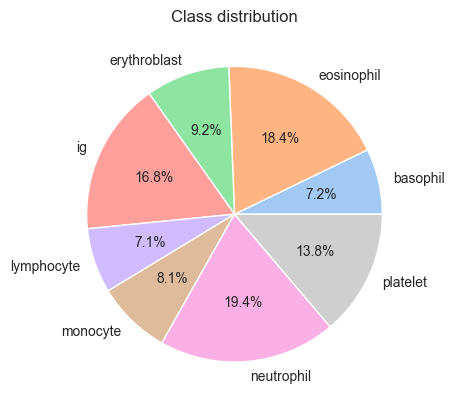

In [5]:
#Etiket dağılımını grafikte gösterme 
labels = np.concatenate([label for image, label in negative_dataset], axis=0)
unique, counts = np.unique(labels, return_counts=True)
plt.pie(x=counts, labels=negative_class_names, autopct='%.1f%%', textprops={'size': 'smaller'},
        colors=sns.color_palette('pastel')[0:8])
plt.title("Class distribution")
plt.show()

In [6]:
# Veri kümesini eğitim ve doğrulama setine ayırma 
num_elements = len(negative_dataset)
train_size = int(0.8 * num_elements)
val_dataset = negative_dataset.skip(train_size).prefetch(tf.data.AUTOTUNE)
train_dataset = negative_dataset.take(train_size).prefetch(tf.data.AUTOTUNE)

# uzunlukları kontrol etme 
len(train_dataset), len(val_dataset), len(negative_test_dataset)

(342, 86, 107)

In [7]:
# Formatı kontrol etme
# Görüntünün boyutlarını kontrol etme
for image_batch, labels_batch in train_dataset.take(1):
  print(f"Train data: {image_batch.shape}")
  print(f"Train labels: {labels_batch.shape}")

for image_batch, labels_batch in val_dataset.take(1):
  print(f"Validation data: {image_batch.shape}")
  print(f"Validation labels: {labels_batch.shape}")

for image_batch, labels_batch in negative_test_dataset.take(1):
  print(f"Test data: {image_batch.shape}")
  print(f"Test labels: {labels_batch.shape}")

Train data: (32, 224, 224, 3)
Train labels: (32,)
Validation data: (32, 224, 224, 3)
Validation labels: (32,)
Test data: (32, 224, 224, 3)
Test labels: (32,)


In [8]:
# Piksel yoğunluklarını kontrol etme
for image, label in train_dataset.take(1):
  print(tf.reduce_max(image))
  print(tf.reduce_min(image))

tf.Tensor(252.31161, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)


In [9]:
# 
lab_book = {}

# early stopping callback oluşturma
early_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True,
                                         monitor="val_accuracy", min_delta=0.005)

In [10]:
name = "Model"

# modeli oluşturma
tf.random.set_seed(42)
model = keras.Sequential(
    [layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
     layers.Rescaling(1./255),
     layers.Conv2D(filters=8, kernel_size=(3,3),
                   padding="same", activation="relu",
                   kernel_initializer="he_normal"),
     layers.MaxPool2D(),
     layers.Flatten(),
     layers.Dense(8, activation="softmax")
     ], name=name)

model.summary()

# modeli derleme işlemi
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])


history = model.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=100,
                        callbacks=[early_cb])


train_accuracy = model.evaluate(train_dataset)[1]
val_accuracy = model.evaluate(val_dataset)[1]
lab_book[name] = {"train_accuracy": train_accuracy, "val_accuracy": val_accuracy}

Model: "Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │         802,824 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 803,048 (3.06 MB)

 Trainable params: 803,048 (3.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 37s 103ms/step - accuracy: 0.5670 - loss: 1.9191 - val_accuracy: 0.8297 - val_loss: 0.5494
Epoch 2/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 35s 101ms/step - accuracy: 0.8481 - loss: 0.4375 - val_accuracy: 0.8333 - val_loss: 0.5090
Epoch 3/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 36s 104ms/step - accuracy: 0.9204 - loss: 0.2641 - val_accuracy: 0.8733 - val_loss: 0.3938
Epoch 4/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 34s 99ms/step - accuracy: 0.9525 - loss: 0.1650 - val_accuracy: 0.8700 - val_loss: 0.3938
Epoch 5/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 37s 108ms/step - accuracy: 0.9759 - loss: 0.1105 - val_accuracy: 0.8656 - val_loss: 0.4053
Epoch 6/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 34s 99ms/step - accuracy: 0.9854 - loss: 0.0689 - val_accuracy: 0.8648 - val_loss: 0.4439
Epoch 7/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 37s 108ms/step - accuracy: 0.9941 - loss: 0.0449 - val_accuracy: 0.8828 - val_loss: 0.3854
Epoch 8/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 35s 103ms/step - accuracy: 0.9941 - l

In [11]:
# veri artırma katmanlarını ayarlama
#data_augmentation = keras.Sequential([
    #keras.layers.RandomFlip("horizontal_and_vertical"),
    #keras.layers.RandomRotation(0.4)
    #])

In [13]:
# modelin test setinin doğruluğunun tahmin edilmesi
test_scores = {}
test_accuracy = model.evaluate(negative_test_dataset)[1]
test_scores["Model"] = test_accuracy

107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.8776 - loss: 0.3898


In [15]:
# 
y_pred = []
y_pred_proba = []
y_true = []


# veri kümesi üzerinde yineleme işlemi
for image_batch, label_batch in negative_test_dataset:
   y_true.append(label_batch)
   preds = model.predict(image_batch, verbose=0)
   y_pred_proba.append(preds)
   y_pred.append(np.argmax(preds, axis=-1))

    
correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = tf.cast(correct_labels, "int64")
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

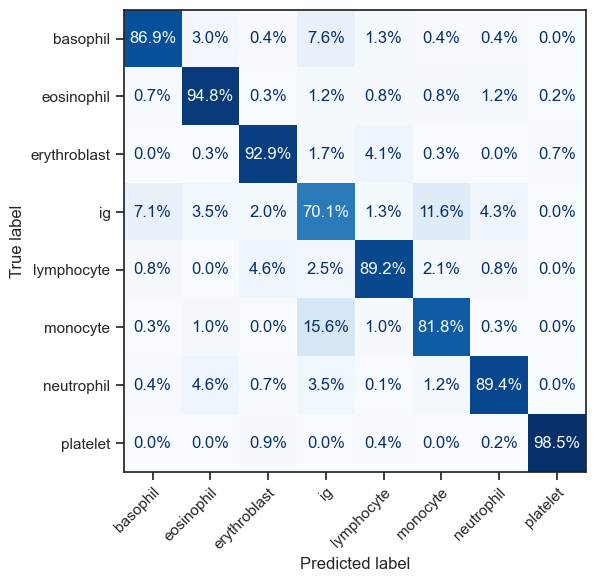

In [18]:
# modelin confusion matrisini gösterme
fig, axes = plt.subplots(figsize=(10,6))
ConfusionMatrixDisplay.from_predictions(y_true=correct_labels,
                                        y_pred=predicted_labels,
                                        display_labels=negative_class_names,
                                        normalize="true",
                                        cmap="Blues",
                                        values_format=".1%",
                                        colorbar=False,
                                        ax=axes)
axes.set_xticklabels(labels=negative_class_names, rotation=45,
                     ha='right',
                     rotation_mode='anchor')
plt.show()

In [21]:
model.save("87negatifmodel.keras")